### Schrödingergleichung

$$i\hbar\frac{\partial \psi(x,t)}{\partial t} = \hat{H} \psi(x,t)$$

- Für zeitunabhängige Hamiltonoperatoren ist die Zeitentwicklung eines Zustands

    $$\psi(x,t) = \sum_{n=0}^{\infty} c_n e^{-iE_n(t-t_0)/\hbar } \,\phi^{(n)}(x), \quad c_n = \langle \phi^{(n)}|\psi(t_0)\rangle$$

    mit orthogonalen Eigenzuständen $\phi^{(n)}$ und reellen Energieeigenwerten $E_n$ als Lösung der stationären Schrödingergleichung

    $$\hat{H}\phi = E\phi$$

### Eigenzustände - numerisch

Räumlich beschränktes Teilchen in 1D

$$\hat{H} = -\frac{\hbar^2}{2m}\frac{\mathrm{d}^2}{\mathrm{d}x^2} + V(x)$$

$$\phi(0) = \phi(L) = 0$$

$$\langle\phi|\psi\rangle = \int_0^L \phi^*(x) \psi(x) \mathrm{d}x$$

- Dimensionslose Größen ($x' = x / L, t' = \frac{t}{mL^2}, V' = mL^2V, E' = mL^2E$, wobei im Folgenden $'$ weggelassen) und Konvention $\hbar=1$:

    $$\left[-\frac{1}{2}\frac{\mathrm{d}^2}{\mathrm{d}{x}^2} + V(x)\right]\mathclose{}\phi(x) = E\phi(x)$$

    $$\phi(0) = \phi(1) = 0$$

- Diskretisierung ($\phi_j \approx \frac{\phi_{j-1}-2\phi_j+\phi_{j+1}}{\Delta x^2}$ mit $\phi_j = \phi(j\Delta x);\: \phi_0 = \phi_N = 0;\: \Delta x = 1/N$ ) ergibt ein lineares System mit tridiagonaler Matrix:

    $$
    \begin{bmatrix}\frac{1}{\Delta x^2}+V_1 & -\frac{1}{2 \Delta x^2} & \hphantom{\frac{1}{\Delta x^2}+V_1} &\\[10pt]
    -\frac{1}{2 \Delta x^2} & \ddots & \ddots &\\[10pt]
    & \ddots & \ddots & -\frac{1}{2 \Delta x^2}\\[10pt]
    & \hphantom{\frac{1}{\Delta x^2}+V_1} & -\frac{1}{2 \Delta x^2} & \frac{1}{\Delta x^2}+V_{N-1}\end{bmatrix}
    \begin{bmatrix} \phi_1 \\ \vdots \\ \phi_{N-1} \end{bmatrix} = E \begin{bmatrix} \phi_1 \\ \vdots \\ \phi_{N-1} \end{bmatrix}
    $$

### Implementation

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from scipy.integrate import quad
import plotly.graph_objects as go

def eigenstates(potential, N=500):
    """
    Lösung für ein räumlich beschränktes Teilchen.

    Parameters:
    -----------
    N : int, optional (default=500)
        Anzahl der Diskretisierungspunkte.
    
    Returns:
    --------
    x : numpy.ndarray, shape (N,)
        Positionen.
    E_n : numpy.ndarray, shape (N-2,)
        Energieeigenwerte.
    phi_n : numpy.ndarray, shape (N-2, N)
        Eigenzustände phi_n(x) in Zeilen.
    """
    N -= 1
    dx = 1 / N
    x = np.linspace(0, 1, N+1)
    d = 1/dx**2 + np.vectorize(potential)(x[1:-1]) # diagonal
    e = np.full(len(d)-1, -1/(2*dx**2)) # off-diagonal
    E_n, phi_n = eigh_tridiagonal(d, e)
    phi_n = np.pad(phi_n.T, ((0, 0), (1, 1))) # include boundary values
    norm = np.sum(np.square(np.abs(phi_n)), axis=1) * dx # normalize rows
    phi_n /= norm[:, np.newaxis]
    return x, E_n, phi_n

def eigenstates_animation(x, E_n, phi_n, n_max=20):
    # TODO: phi_n complex?
    E_n = E_n[:n_max+1]
    phi_n = phi_n[:n_max+1,:]
    fig = go.Figure()
    # Add traces and steps for time-slider
    steps = []
    for i, E_i in enumerate(E_n):
        fig.add_trace(
            go.Scatter(
                visible=False,
                name=f'Wellenfunktion $\phi_{{n={i}}}(x)$',
                x=x,
                y=phi_n[i,:],
                line=dict(color='rgb(31, 119, 180)')
            )
        )

        visible = [False] * len(E_n)
        visible[i] = True
        step = dict(
            method="update",
            args=[{"visible": visible}, {"title": f"Eigenzustand zu $E_{{{i}}} = {E_i:.2f}$ TODO:Einheiten."}],
            label=str(i)
        )
        steps.append(step)
        
    """
    # Add plot of func as last trace
    fig.add_trace(
        go.Scatter(
            visible=True,
            name=rf'${func_name}$',
            x=xx,
            y=func(xx),
            line=dict(color='rgb(255, 127, 14)')
        )
    ) 
    """

    # Create slider
    slider = go.layout.Slider(
        currentvalue = {"prefix": "n: "},
        pad = {"t": 50},
        steps = steps
    )

    fig.update_layout(
        sliders=[slider],
        title="",
        showlegend=True,
        yaxis=dict(range=[np.min(phi_n)*1.05, np.max(phi_n)*1.05])
        )

    fig.show() # fig.write_html(f"ani.html", include_mathjax='cdn')

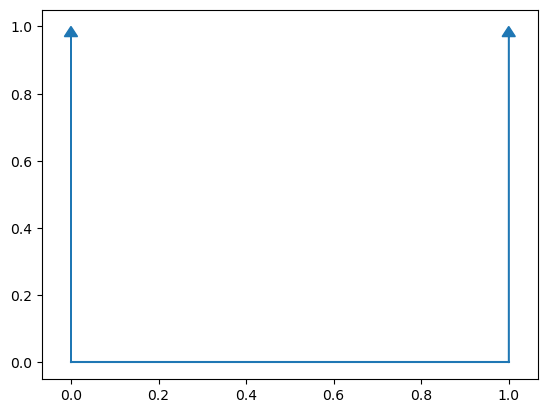

In [31]:
#def potential(x, mu=0.7, sigma=0.05):
#    return -1e4 * np.exp(-(x - mu)**2 / (2*sigma**2))

def potential(x):
    return 0

x, E_n, phi_n = eigenstates(potential)

fig = plt.figure() # potential plot
plt.arrow(0, 0, 0, 1, color='tab:blue', length_includes_head=True, head_width=0.03, head_length=0.03)
plt.arrow(1, 0, 0, 1, color='tab:blue', length_includes_head=True, head_width=0.03, head_length=0.03)
plt.plot(x, np.vectorize(potential)(x))

eigenstates_animation(x, E_n, phi_n)

TODO

- plot analytical solutions
- potential plot with infinity walls
- nicer plots, units, show first frame initially